### Modelling Time Series

    * Moving average
    * Exponential smoothing
    * ARIMA

In [101]:
import csv
import pandas as pd
import numpy as np

import yfinance as yf
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

In [97]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [98]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [11]:
today = datetime.today().date()

start_date = None
end_date = None


### Predicting stock price 

We will use the historical stock price of the New Germany Fund (GF) to try to predict the closing price in the next five trading days.

In [19]:
if not start_date:
    start_date = today - relativedelta(months=6)

if not end_date:
    end_date = today

In [21]:

print(f"Start: {start_date} End: {end_date}")

Start: 2020-12-26 End: 2021-06-26


In [82]:
tickers = ['TSLA']
HISTORICAL_PRICES_COLUMNS = ['open','high','low','close','volume']


In [83]:
ticker_yf = yf.Ticker('TSLA')
df_prices = ticker_yf.history(start = start_date, end = end_date)

In [84]:
df_prices.index.names = [c.lower().replace(' ', '_') for c in df_prices.index.names]
df_prices.columns = [c.lower().replace(' ', '_') for c in df_prices.columns]
df_prices = df_prices[HISTORICAL_PRICES_COLUMNS]

In [85]:
df_prices.head(1)

,open,high,low,close,volume
date,,,,,
2020-12-28,674.51001,681.400024,660.799988,663.690002,32278600


Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

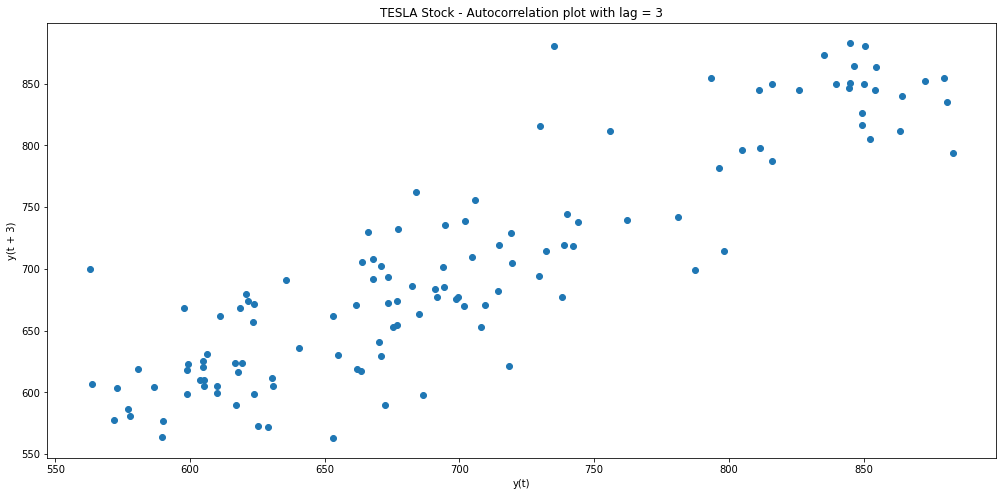

In [86]:

plt.figure(figsize=(17, 8))
lag_plot(df_prices['close'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

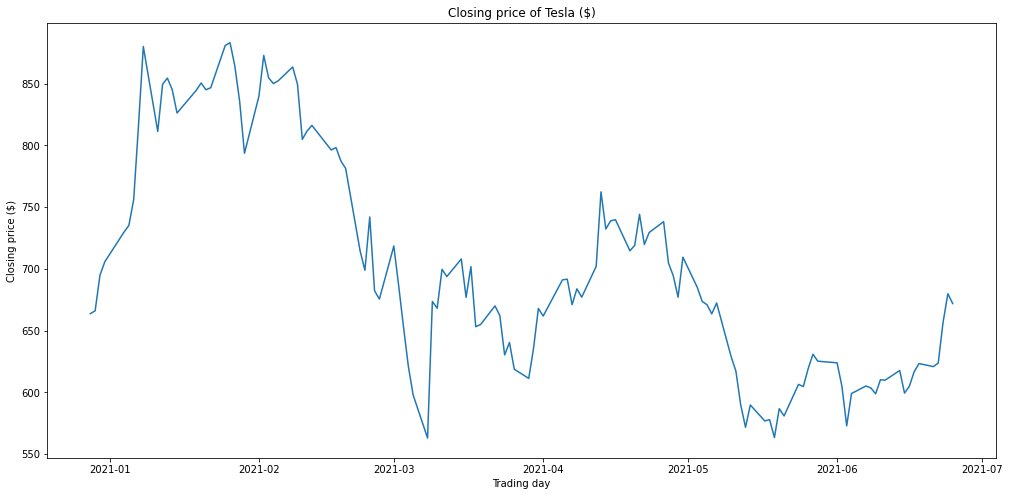

In [87]:
# Plot closing price

plt.figure(figsize=(17, 8))
plt.plot(df_prices['close'])
plt.title('Closing price of Tesla ($)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [88]:
# Normalising prices

df_normalized_prices = pd.DataFrame((df_prices['close'] / df_prices['close'].iloc[0]), columns=['close'] )

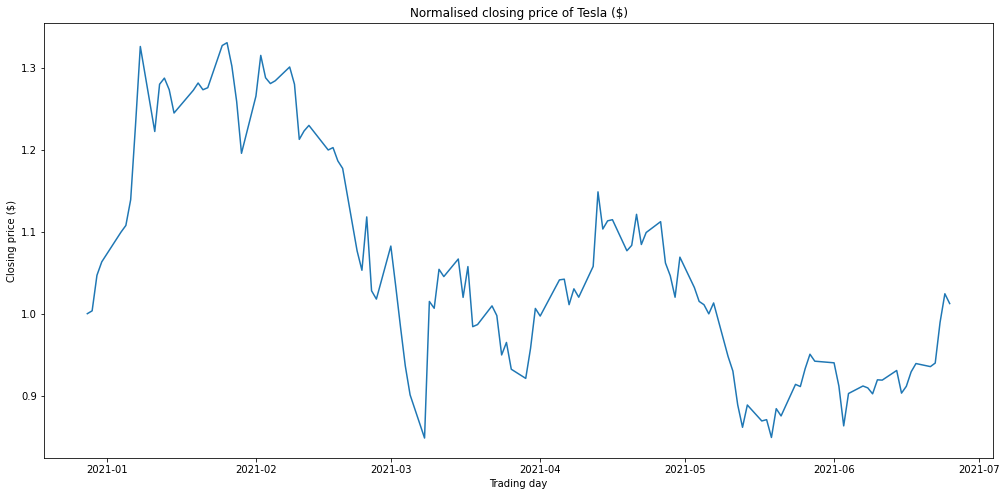

In [91]:
plt.figure(figsize=(17, 8))
plt.plot(df_normalized_prices['close'])
plt.title('Normalised closing price of Tesla ($)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [105]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

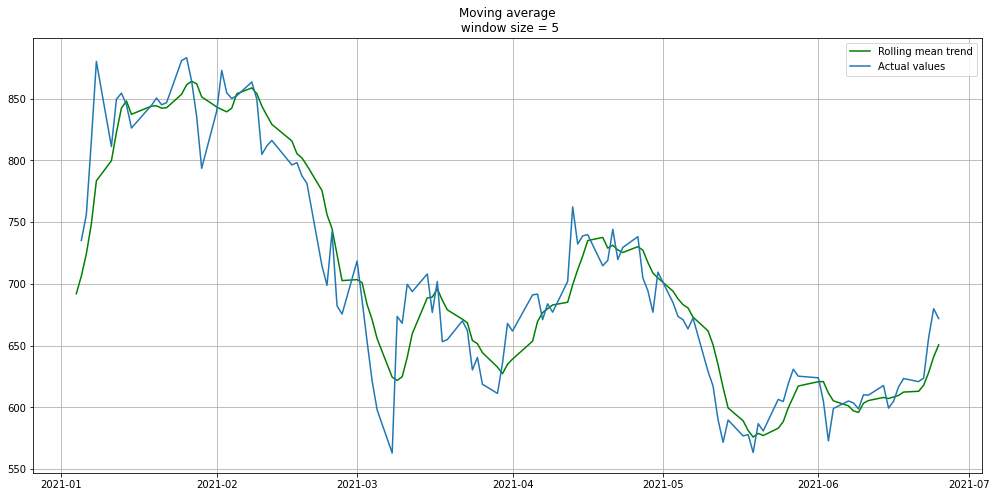

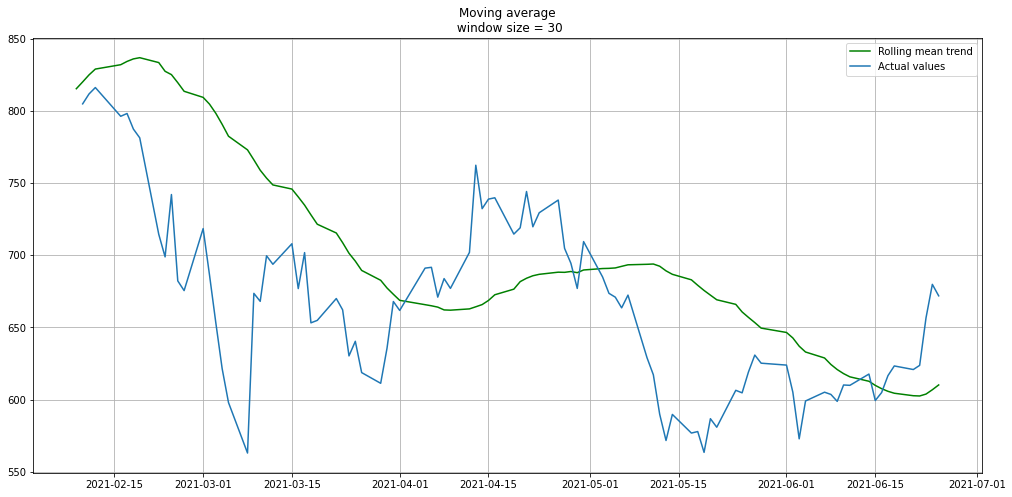

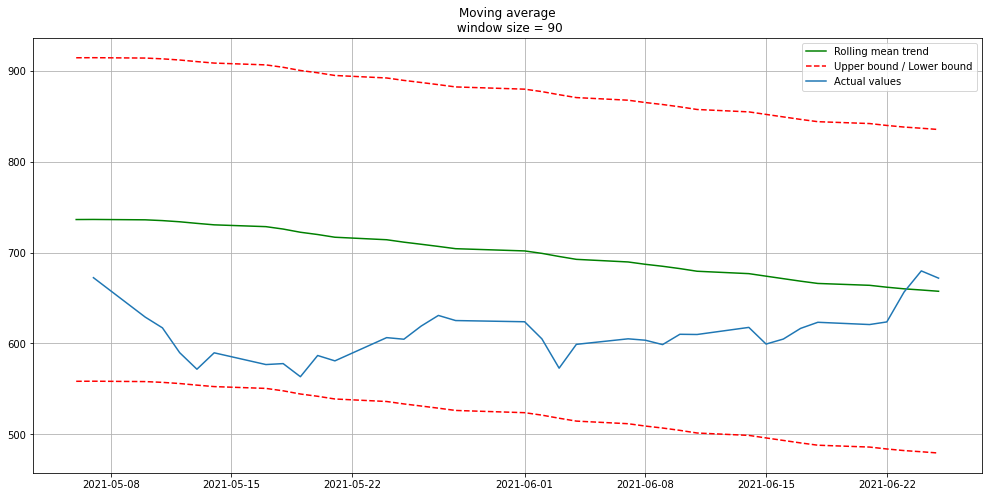

In [102]:
#Smooth by the previous 5 days (by week)
plot_moving_average(df_prices['close'], 5)

#Smooth by the previous month (30 days)
plot_moving_average(df_prices['close'], 30)

#Smooth by previous quarter (90 days)
plot_moving_average(df_prices['close'], 90, plot_intervals=True)

### Exponential smoothing

To see if it pick up a better trend

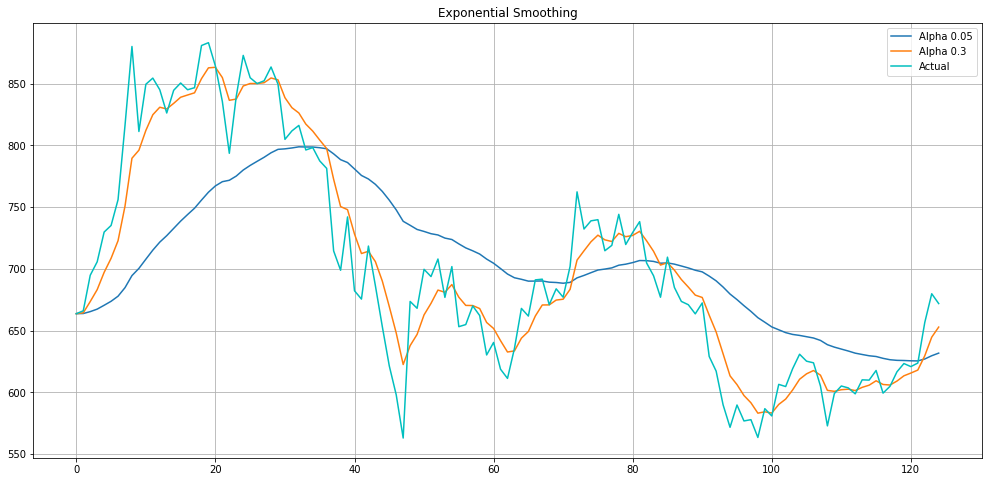

In [107]:
plot_exponential_smoothing(df_prices['close'], [0.05, 0.3])

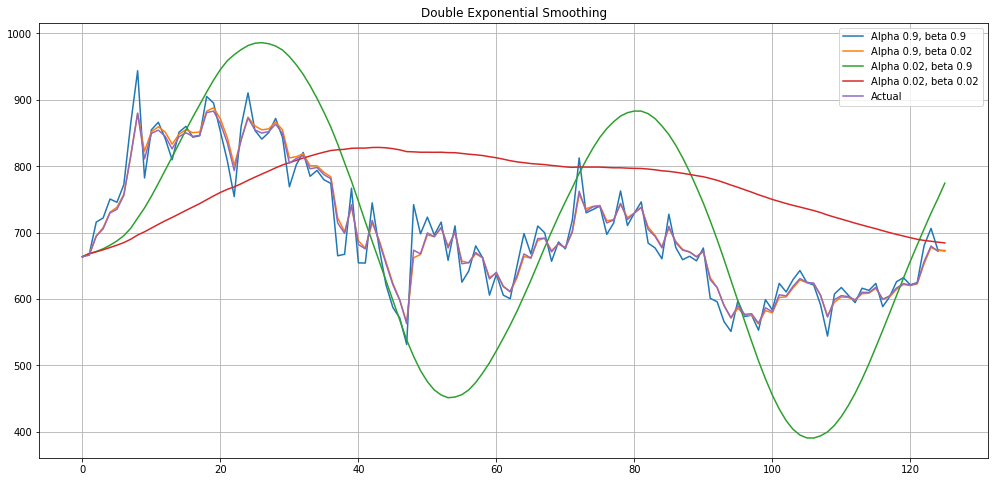

In [108]:
plot_double_exponential_smoothing(df_prices['close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

### ARIMA model

There is auto-correlation in the data. The close price evolves over time. 

https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70